# Level Set Method for Interface Tracking

## Introduction

The **Level Set Method** is a powerful numerical technique for tracking the evolution of interfaces and shapes. Introduced by Osher and Sethian in 1988, this method represents interfaces implicitly as the zero level set of a higher-dimensional function, enabling elegant handling of topological changes such as merging and splitting.

## Mathematical Foundation

### Implicit Interface Representation

Instead of explicitly tracking points on an interface $\Gamma$, we embed the interface as the zero level set of a continuous function $\phi(\mathbf{x}, t)$:

$$\Gamma(t) = \{\mathbf{x} \in \mathbb{R}^n : \phi(\mathbf{x}, t) = 0\}$$

The function $\phi$ is typically chosen as a **signed distance function**:

$$\phi(\mathbf{x}, t) = \begin{cases} +d(\mathbf{x}, \Gamma) & \text{if } \mathbf{x} \text{ is outside } \Gamma \\ 0 & \text{if } \mathbf{x} \in \Gamma \\ -d(\mathbf{x}, \Gamma) & \text{if } \mathbf{x} \text{ is inside } \Gamma \end{cases}$$

where $d(\mathbf{x}, \Gamma)$ is the Euclidean distance from $\mathbf{x}$ to the interface.

### Level Set Evolution Equation

If the interface moves with velocity $\mathbf{v}(\mathbf{x}, t)$, the level set function evolves according to the **level set equation**:

$$\frac{\partial \phi}{\partial t} + \mathbf{v} \cdot \nabla \phi = 0$$

For motion in the **normal direction** with speed $F$, where $\mathbf{n} = \frac{\nabla \phi}{|\nabla \phi|}$ is the outward unit normal, the equation becomes:

$$\frac{\partial \phi}{\partial t} + F|\nabla \phi| = 0$$

### Geometric Quantities

The level set framework provides natural expressions for geometric quantities:

**Unit Normal Vector:**
$$\mathbf{n} = \frac{\nabla \phi}{|\nabla \phi|}$$

**Mean Curvature (2D):**
$$\kappa = \nabla \cdot \left(\frac{\nabla \phi}{|\nabla \phi|}\right) = \frac{\phi_{xx}\phi_y^2 - 2\phi_x\phi_y\phi_{xy} + \phi_{yy}\phi_x^2}{(\phi_x^2 + \phi_y^2)^{3/2}}$$

### Curvature-Driven Motion

A particularly important case is **motion by mean curvature**, where $F = -\kappa$:

$$\frac{\partial \phi}{\partial t} = \kappa |\nabla \phi| = \nabla \cdot \left(\frac{\nabla \phi}{|\nabla \phi|}\right)|\nabla \phi|$$

This smooths the interface over time and is fundamental in image processing and materials science.

## Numerical Implementation

In this notebook, we implement:
1. Initialization of signed distance functions
2. Advection with an external velocity field
3. Motion by mean curvature
4. Reinitialization to maintain the signed distance property

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.ndimage import laplace

# Set up the computational domain
nx, ny = 200, 200
Lx, Ly = 4.0, 4.0
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)

x = np.linspace(-Lx/2, Lx/2, nx)
y = np.linspace(-Ly/2, Ly/2, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

print(f"Domain: [{-Lx/2}, {Lx/2}] x [{-Ly/2}, {Ly/2}]")
print(f"Grid: {nx} x {ny}, dx = dy = {dx:.4f}")

Domain: [-2.0, 2.0] x [-2.0, 2.0]
Grid: 200 x 200, dx = dy = 0.0201


## Signed Distance Function Initialization

We initialize $\phi$ as the signed distance function for a circle centered at $(x_0, y_0)$ with radius $R$:

$$\phi(x, y) = \sqrt{(x - x_0)^2 + (y - y_0)^2} - R$$

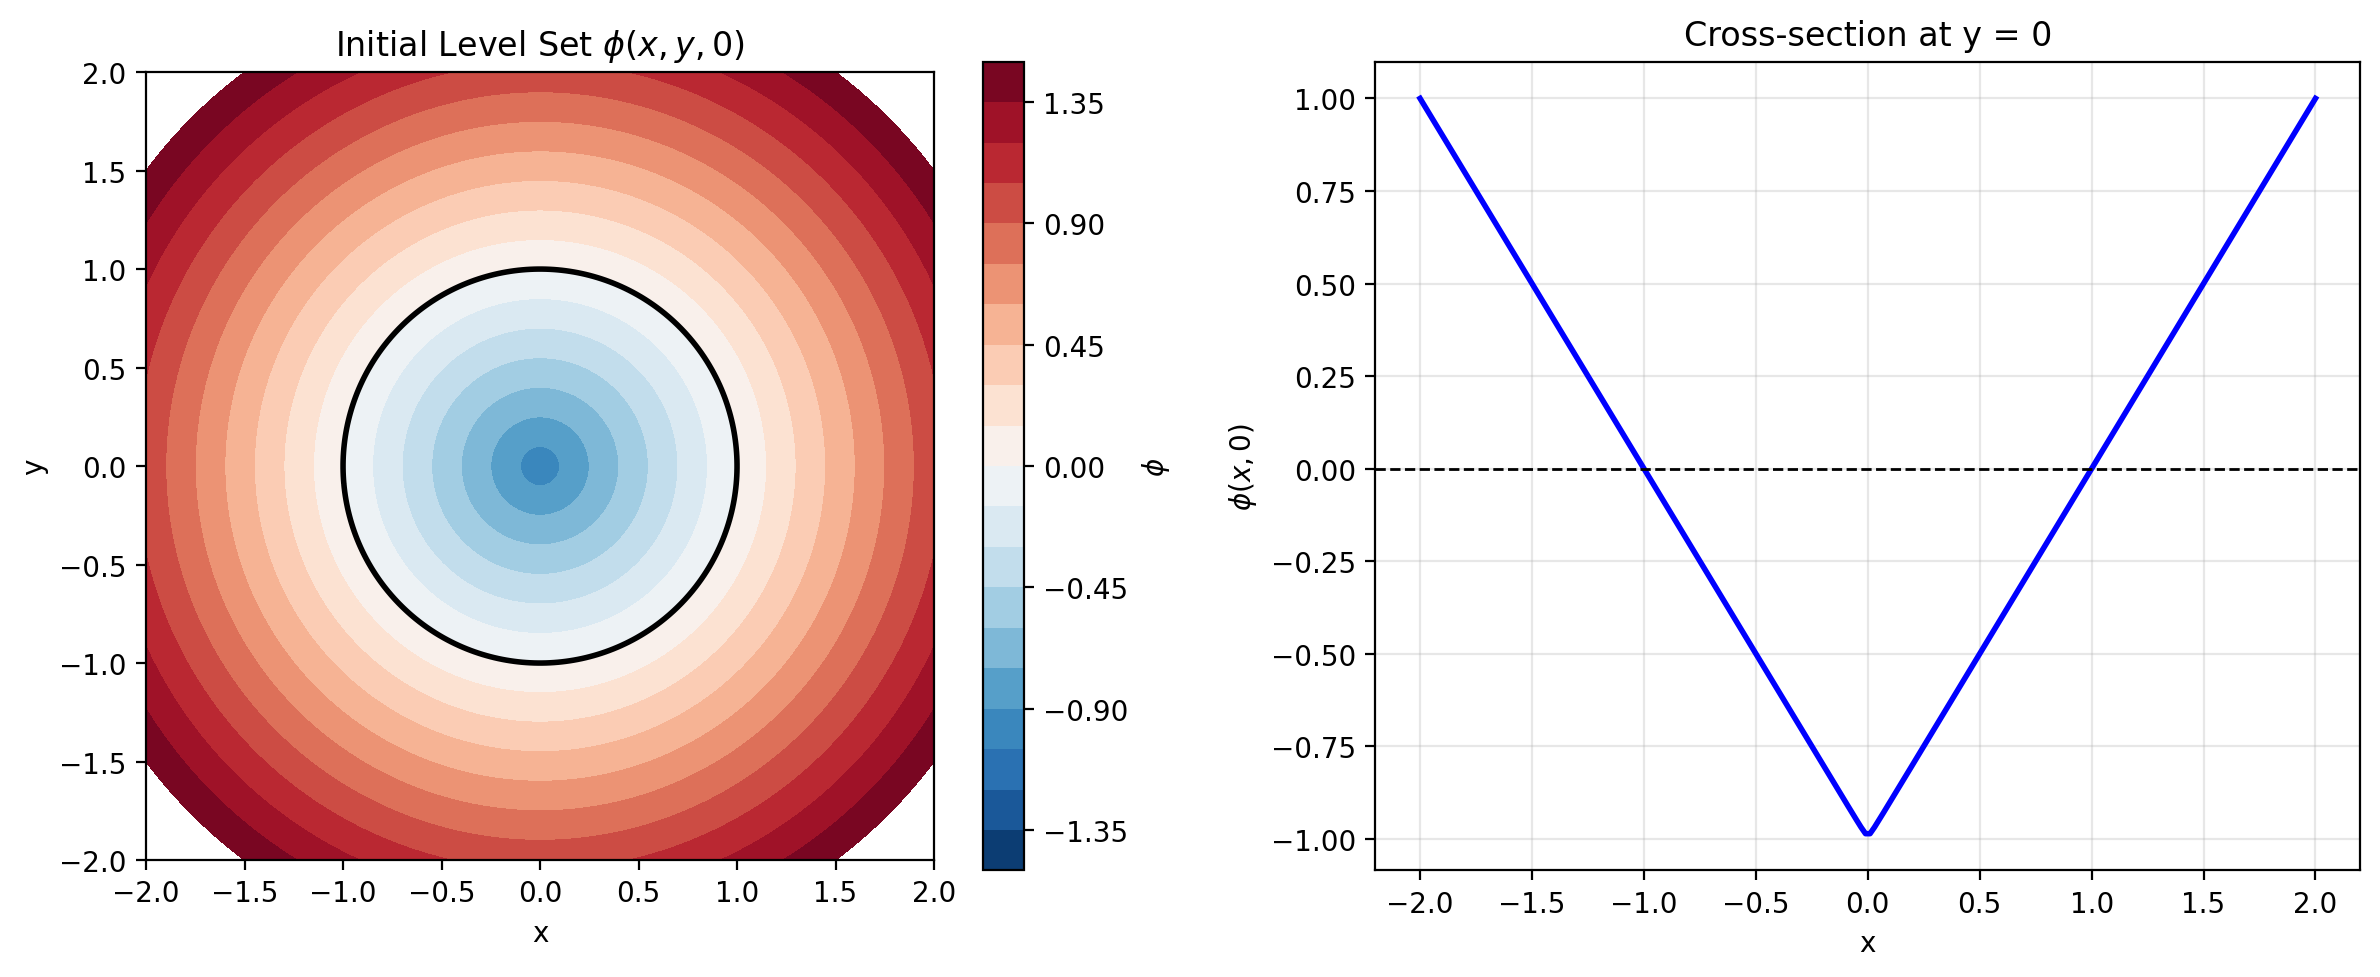

In [2]:
def initialize_circle(X, Y, x0, y0, radius):
    """Initialize signed distance function for a circle."""
    return np.sqrt((X - x0)**2 + (Y - y0)**2) - radius

def initialize_two_circles(X, Y, x1, y1, r1, x2, y2, r2):
    """Initialize signed distance function for union of two circles."""
    phi1 = np.sqrt((X - x1)**2 + (Y - y1)**2) - r1
    phi2 = np.sqrt((X - x2)**2 + (Y - y2)**2) - r2
    return np.minimum(phi1, phi2)  # Union operation

def initialize_star(X, Y, x0, y0, r_inner, r_outer, n_points):
    """Initialize signed distance function for a star shape (approximate)."""
    r = np.sqrt((X - x0)**2 + (Y - y0)**2)
    theta = np.arctan2(Y - y0, X - x0)
    r_boundary = r_inner + (r_outer - r_inner) * 0.5 * (1 + np.cos(n_points * theta))
    return r - r_boundary

# Initialize with a circle
phi_initial = initialize_circle(X, Y, 0.0, 0.0, 1.0)

# Visualize the initial condition
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Contour plot
ax1 = axes[0]
levels = np.linspace(-1.5, 1.5, 21)
cs = ax1.contourf(X, Y, phi_initial, levels=levels, cmap='RdBu_r')
ax1.contour(X, Y, phi_initial, levels=[0], colors='k', linewidths=2)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(r'Initial Level Set $\phi(x,y,0)$')
ax1.set_aspect('equal')
plt.colorbar(cs, ax=ax1, label=r'$\phi$')

# Cross-section
ax2 = axes[1]
mid_idx = ny // 2
ax2.plot(x, phi_initial[:, mid_idx], 'b-', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax2.set_xlabel('x')
ax2.set_ylabel(r'$\phi(x, 0)$')
ax2.set_title('Cross-section at y = 0')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Numerical Schemes for Level Set Evolution

### Upwind Scheme for Advection

For the advection equation $\phi_t + \mathbf{v} \cdot \nabla \phi = 0$, we use first-order upwind differencing:

$$\phi_x^- = \frac{\phi_{i,j} - \phi_{i-1,j}}{\Delta x}, \quad \phi_x^+ = \frac{\phi_{i+1,j} - \phi_{i,j}}{\Delta x}$$

The upwind selection depends on the sign of velocity:
$$v_x \phi_x \approx \max(v_x, 0)\phi_x^- + \min(v_x, 0)\phi_x^+$$

### Curvature Computation

Central differences are used for computing curvature.

In [3]:
def compute_gradient(phi, dx, dy):
    """Compute gradient using central differences."""
    phi_x = np.zeros_like(phi)
    phi_y = np.zeros_like(phi)
    
    # Central differences for interior
    phi_x[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
    phi_y[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dy)
    
    # One-sided differences at boundaries
    phi_x[0, :] = (phi[1, :] - phi[0, :]) / dx
    phi_x[-1, :] = (phi[-1, :] - phi[-2, :]) / dx
    phi_y[:, 0] = (phi[:, 1] - phi[:, 0]) / dy
    phi_y[:, -1] = (phi[:, -1] - phi[:, -2]) / dy
    
    return phi_x, phi_y

def compute_gradient_upwind(phi, vx, vy, dx, dy):
    """Compute upwind gradient based on velocity direction."""
    phi_x = np.zeros_like(phi)
    phi_y = np.zeros_like(phi)
    
    # Backward differences
    phi_x_minus = np.zeros_like(phi)
    phi_x_minus[1:, :] = (phi[1:, :] - phi[:-1, :]) / dx
    
    phi_y_minus = np.zeros_like(phi)
    phi_y_minus[:, 1:] = (phi[:, 1:] - phi[:, :-1]) / dy
    
    # Forward differences
    phi_x_plus = np.zeros_like(phi)
    phi_x_plus[:-1, :] = (phi[1:, :] - phi[:-1, :]) / dx
    
    phi_y_plus = np.zeros_like(phi)
    phi_y_plus[:, :-1] = (phi[:, 1:] - phi[:, :-1]) / dy
    
    # Upwind selection
    phi_x = np.where(vx > 0, phi_x_minus, phi_x_plus)
    phi_y = np.where(vy > 0, phi_y_minus, phi_y_plus)
    
    return phi_x, phi_y

def compute_curvature(phi, dx, dy):
    """Compute mean curvature of the level set."""
    # First derivatives (central differences)
    phi_x, phi_y = compute_gradient(phi, dx, dy)
    
    # Second derivatives
    phi_xx = np.zeros_like(phi)
    phi_yy = np.zeros_like(phi)
    phi_xy = np.zeros_like(phi)
    
    phi_xx[1:-1, :] = (phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, :]) / dx**2
    phi_yy[:, 1:-1] = (phi[:, 2:] - 2*phi[:, 1:-1] + phi[:, :-2]) / dy**2
    
    # Mixed derivative
    phi_xy[1:-1, 1:-1] = (phi[2:, 2:] - phi[2:, :-2] - phi[:-2, 2:] + phi[:-2, :-2]) / (4*dx*dy)
    
    # Compute curvature with regularization to avoid division by zero
    grad_mag_sq = phi_x**2 + phi_y**2
    eps = 1e-10
    
    kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_mag_sq**1.5 + eps)
    
    return kappa

print("Numerical operators defined successfully.")

Numerical operators defined successfully.


## Advection with External Velocity Field

We first demonstrate interface advection using a vortex velocity field:

$$v_x = -\sin(\pi x)\cos(\pi y), \quad v_y = \cos(\pi x)\sin(\pi y)$$

This creates a swirling motion that deforms the interface.

In [4]:
def vortex_velocity(X, Y, t, T_period):
    """Time-reversing vortex velocity field."""
    cos_t = np.cos(np.pi * t / T_period)
    vx = -np.sin(np.pi * X) * np.cos(np.pi * Y) * cos_t
    vy = np.cos(np.pi * X) * np.sin(np.pi * Y) * cos_t
    return vx, vy

def advect_level_set(phi, vx, vy, dx, dy, dt):
    """Advect level set function using upwind scheme."""
    phi_x, phi_y = compute_gradient_upwind(phi, vx, vy, dx, dy)
    phi_new = phi - dt * (vx * phi_x + vy * phi_y)
    return phi_new

# Parameters for vortex advection
T_period = 4.0  # Time for one full period (forward and back)
dt = 0.005
n_steps = int(T_period / dt)

# Initialize
phi = initialize_circle(X, Y, 0.0, 0.25, 0.15)

# Store snapshots
snapshots = [phi.copy()]
snapshot_times = [0.0]

# Time integration
for step in range(n_steps):
    t = step * dt
    vx, vy = vortex_velocity(X, Y, t, T_period)
    phi = advect_level_set(phi, vx, vy, dx, dy, dt)
    
    # Store snapshots at regular intervals
    if (step + 1) % (n_steps // 8) == 0:
        snapshots.append(phi.copy())
        snapshot_times.append((step + 1) * dt)

print(f"Completed {n_steps} time steps")
print(f"Captured {len(snapshots)} snapshots")

Completed 800 time steps
Captured 9 snapshots


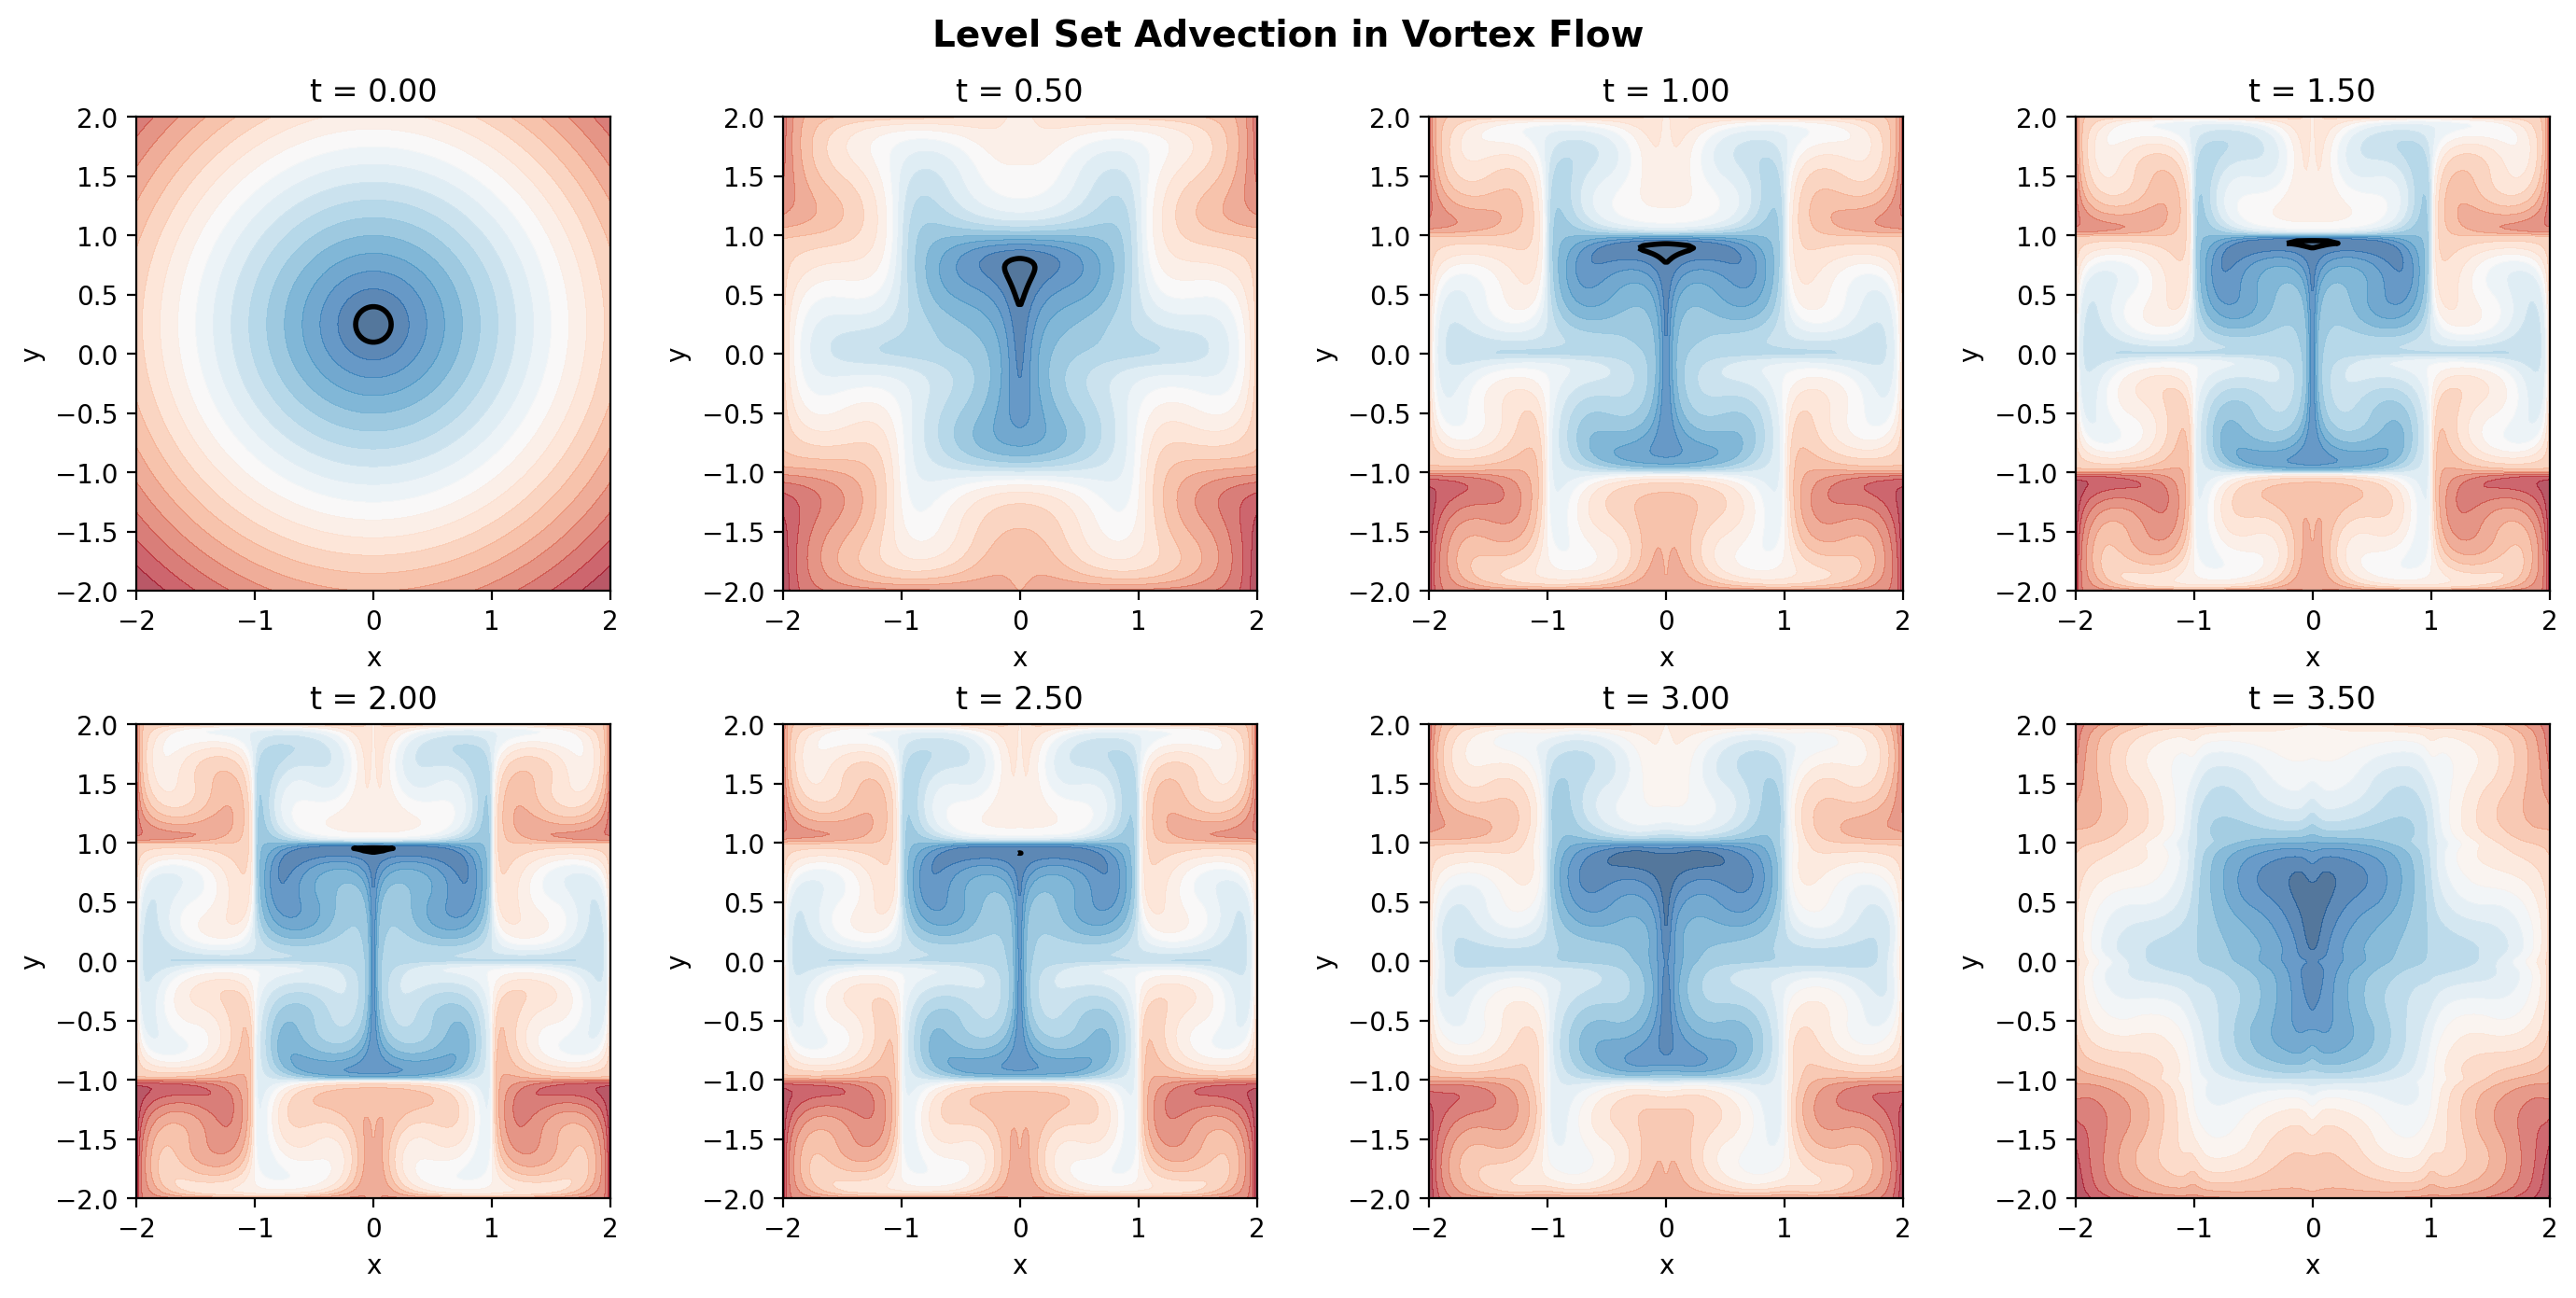

In [5]:
# Visualize the vortex advection
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.flatten()

for idx, (phi_snap, t) in enumerate(zip(snapshots[:8], snapshot_times[:8])):
    ax = axes[idx]
    ax.contourf(X, Y, phi_snap, levels=20, cmap='RdBu_r', alpha=0.7)
    ax.contour(X, Y, phi_snap, levels=[0], colors='k', linewidths=2)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal')
    ax.set_title(f't = {t:.2f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.suptitle('Level Set Advection in Vortex Flow', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Motion by Mean Curvature

Now we implement **curvature-driven motion**, where the interface moves in its normal direction with speed proportional to (negative) mean curvature:

$$\frac{\partial \phi}{\partial t} = \kappa |\nabla \phi|$$

This has the effect of smoothing the interface - regions with high curvature move faster. A circle shrinks uniformly and eventually disappears.

In [6]:
def evolve_by_curvature(phi, dx, dy, dt):
    """Evolve level set by mean curvature flow."""
    kappa = compute_curvature(phi, dx, dy)
    phi_x, phi_y = compute_gradient(phi, dx, dy)
    grad_mag = np.sqrt(phi_x**2 + phi_y**2 + 1e-10)
    
    # Motion by mean curvature (shrinking)
    phi_new = phi + dt * kappa * grad_mag
    return phi_new

# Initialize with a star shape (has varying curvature)
phi_star = initialize_star(X, Y, 0.0, 0.0, 0.5, 1.2, 5)

# Parameters
dt_curv = 0.001  # Smaller time step for stability
n_steps_curv = 500

# Store snapshots
phi = phi_star.copy()
curv_snapshots = [phi.copy()]
curv_times = [0.0]

for step in range(n_steps_curv):
    phi = evolve_by_curvature(phi, dx, dy, dt_curv)
    
    if (step + 1) % (n_steps_curv // 5) == 0:
        curv_snapshots.append(phi.copy())
        curv_times.append((step + 1) * dt_curv)

print(f"Completed curvature evolution: {n_steps_curv} steps")

/tmp/ipykernel_157348/1847190236.py:63: RuntimeWarning: overflow encountered in multiply
  kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_mag_sq**1.5 + eps)
/tmp/ipykernel_157348/1847190236.py:53: RuntimeWarning: invalid value encountered in subtract
  phi_xx[1:-1, :] = (phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, :]) / dx**2
/tmp/ipykernel_157348/1847190236.py:53: RuntimeWarning: invalid value encountered in add
  phi_xx[1:-1, :] = (phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, :]) / dx**2
/tmp/ipykernel_157348/1847190236.py:63: RuntimeWarning: overflow encountered in subtract
  kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_mag_sq**1.5 + eps)
/tmp/ipykernel_157348/1847190236.py:63: RuntimeWarning: invalid value encountered in subtract
  kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_mag_sq**1.5 + eps)
/tmp/ipykernel_157348/1847190236.py:63: RuntimeWarning: overflow encountered in add

Completed curvature evolution: 500 steps


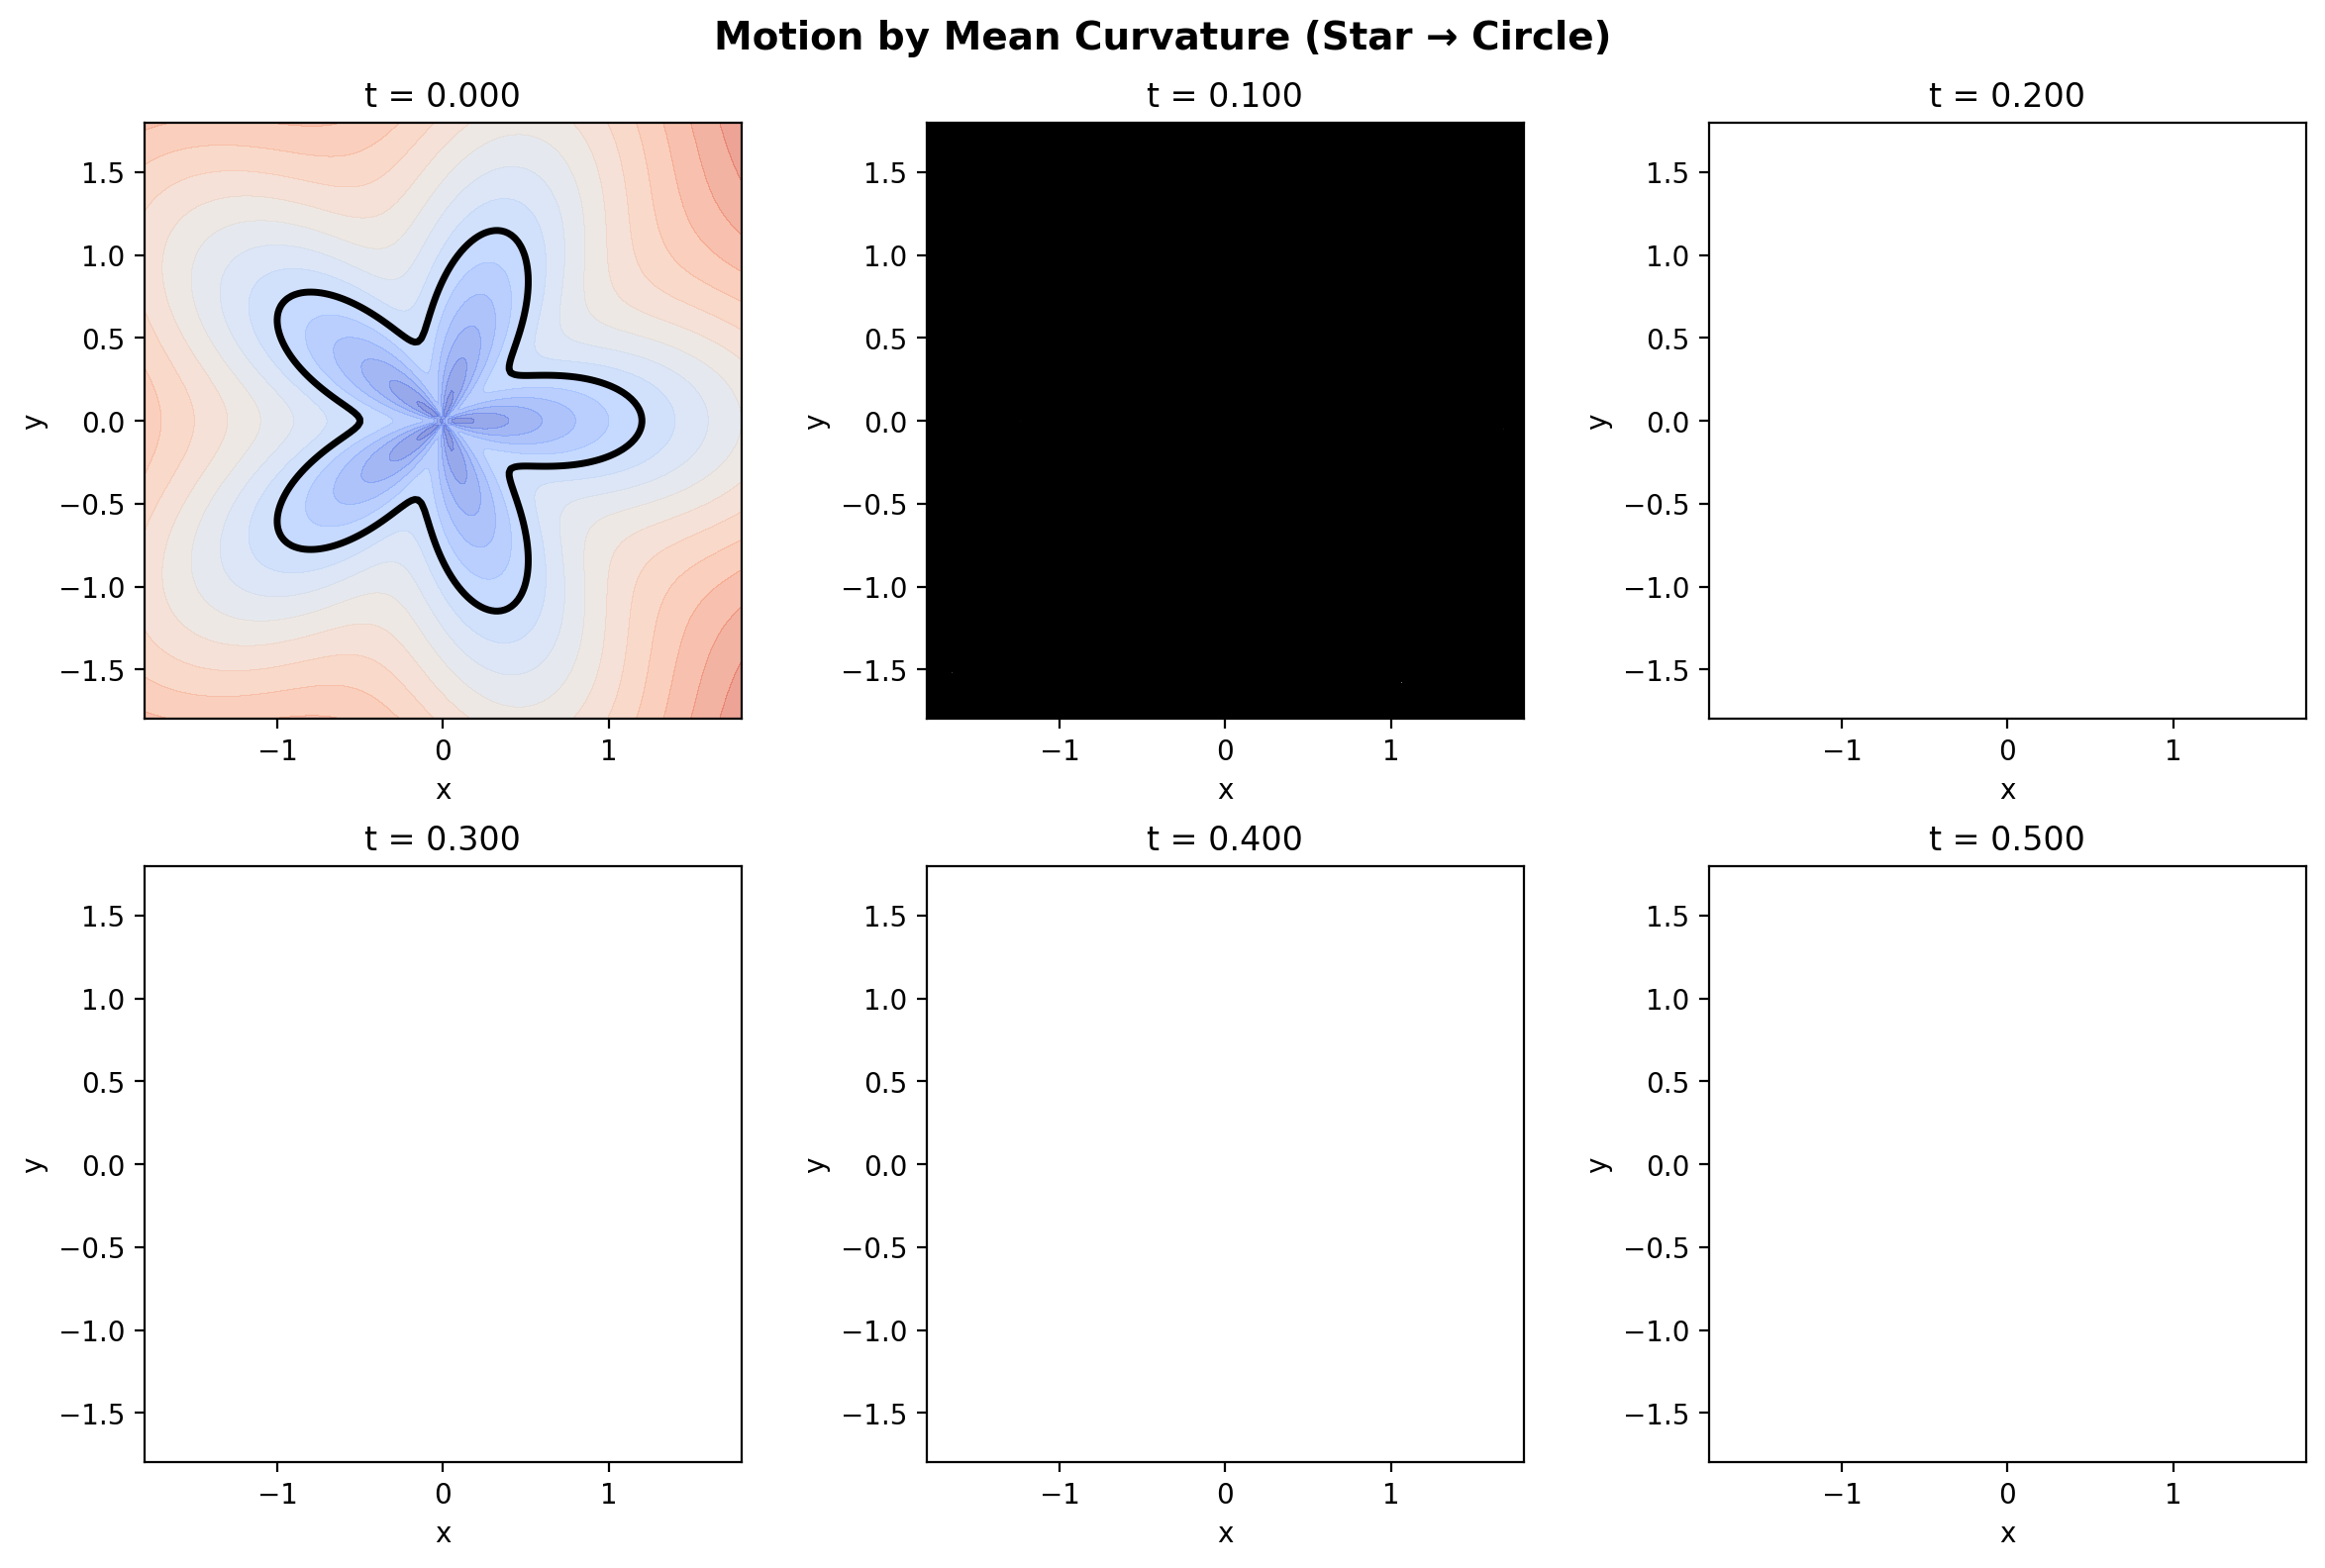

In [7]:
# Visualize curvature flow
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (phi_snap, t) in enumerate(zip(curv_snapshots[:6], curv_times[:6])):
    ax = axes[idx]
    ax.contourf(X, Y, phi_snap, levels=20, cmap='coolwarm', alpha=0.6)
    ax.contour(X, Y, phi_snap, levels=[0], colors='k', linewidths=2.5)
    ax.set_xlim(-1.8, 1.8)
    ax.set_ylim(-1.8, 1.8)
    ax.set_aspect('equal')
    ax.set_title(f't = {t:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.suptitle('Motion by Mean Curvature (Star → Circle)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Topological Changes: Circle Merging

One of the key advantages of the level set method is its natural handling of **topological changes**. Here we demonstrate two circles merging under curvature flow combined with expansion.

In [8]:
def evolve_expansion_curvature(phi, dx, dy, dt, expansion_speed):
    """Evolve with both expansion and curvature regularization."""
    kappa = compute_curvature(phi, dx, dy)
    phi_x, phi_y = compute_gradient(phi, dx, dy)
    grad_mag = np.sqrt(phi_x**2 + phi_y**2 + 1e-10)
    
    # Expansion (negative speed makes phi decrease, expanding the region)
    # Plus curvature smoothing
    phi_new = phi - dt * expansion_speed * grad_mag + 0.3 * dt * kappa * grad_mag
    return phi_new

# Initialize two circles close together
phi_merge = initialize_two_circles(X, Y, -0.6, 0.0, 0.4, 0.6, 0.0, 0.4)

# Parameters
dt_merge = 0.005
n_steps_merge = 200
expansion_speed = 0.5

# Store snapshots
phi = phi_merge.copy()
merge_snapshots = [phi.copy()]
merge_times = [0.0]

for step in range(n_steps_merge):
    phi = evolve_expansion_curvature(phi, dx, dy, dt_merge, expansion_speed)
    
    if (step + 1) % (n_steps_merge // 5) == 0:
        merge_snapshots.append(phi.copy())
        merge_times.append((step + 1) * dt_merge)

print(f"Completed merging simulation: {n_steps_merge} steps")

Completed merging simulation: 200 steps


/tmp/ipykernel_157348/1847190236.py:63: RuntimeWarning: overflow encountered in multiply
  kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_mag_sq**1.5 + eps)
/tmp/ipykernel_157348/1847190236.py:63: RuntimeWarning: overflow encountered in add
  kappa = (phi_xx * phi_y**2 - 2 * phi_x * phi_y * phi_xy + phi_yy * phi_x**2) / (grad_mag_sq**1.5 + eps)
/tmp/ipykernel_157348/1847190236.py:7: RuntimeWarning: invalid value encountered in subtract
  phi_x[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dx)
/tmp/ipykernel_157348/1847190236.py:8: RuntimeWarning: invalid value encountered in subtract
  phi_y[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dy)
/tmp/ipykernel_157348/1847190236.py:53: RuntimeWarning: invalid value encountered in subtract
  phi_xx[1:-1, :] = (phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, :]) / dx**2
/tmp/ipykernel_157348/1847190236.py:53: RuntimeWarning: invalid value encountered in add
  phi_xx[1:-1, :] = (phi[2:, :] - 2*phi[1:-1, :] + phi[:-2, 

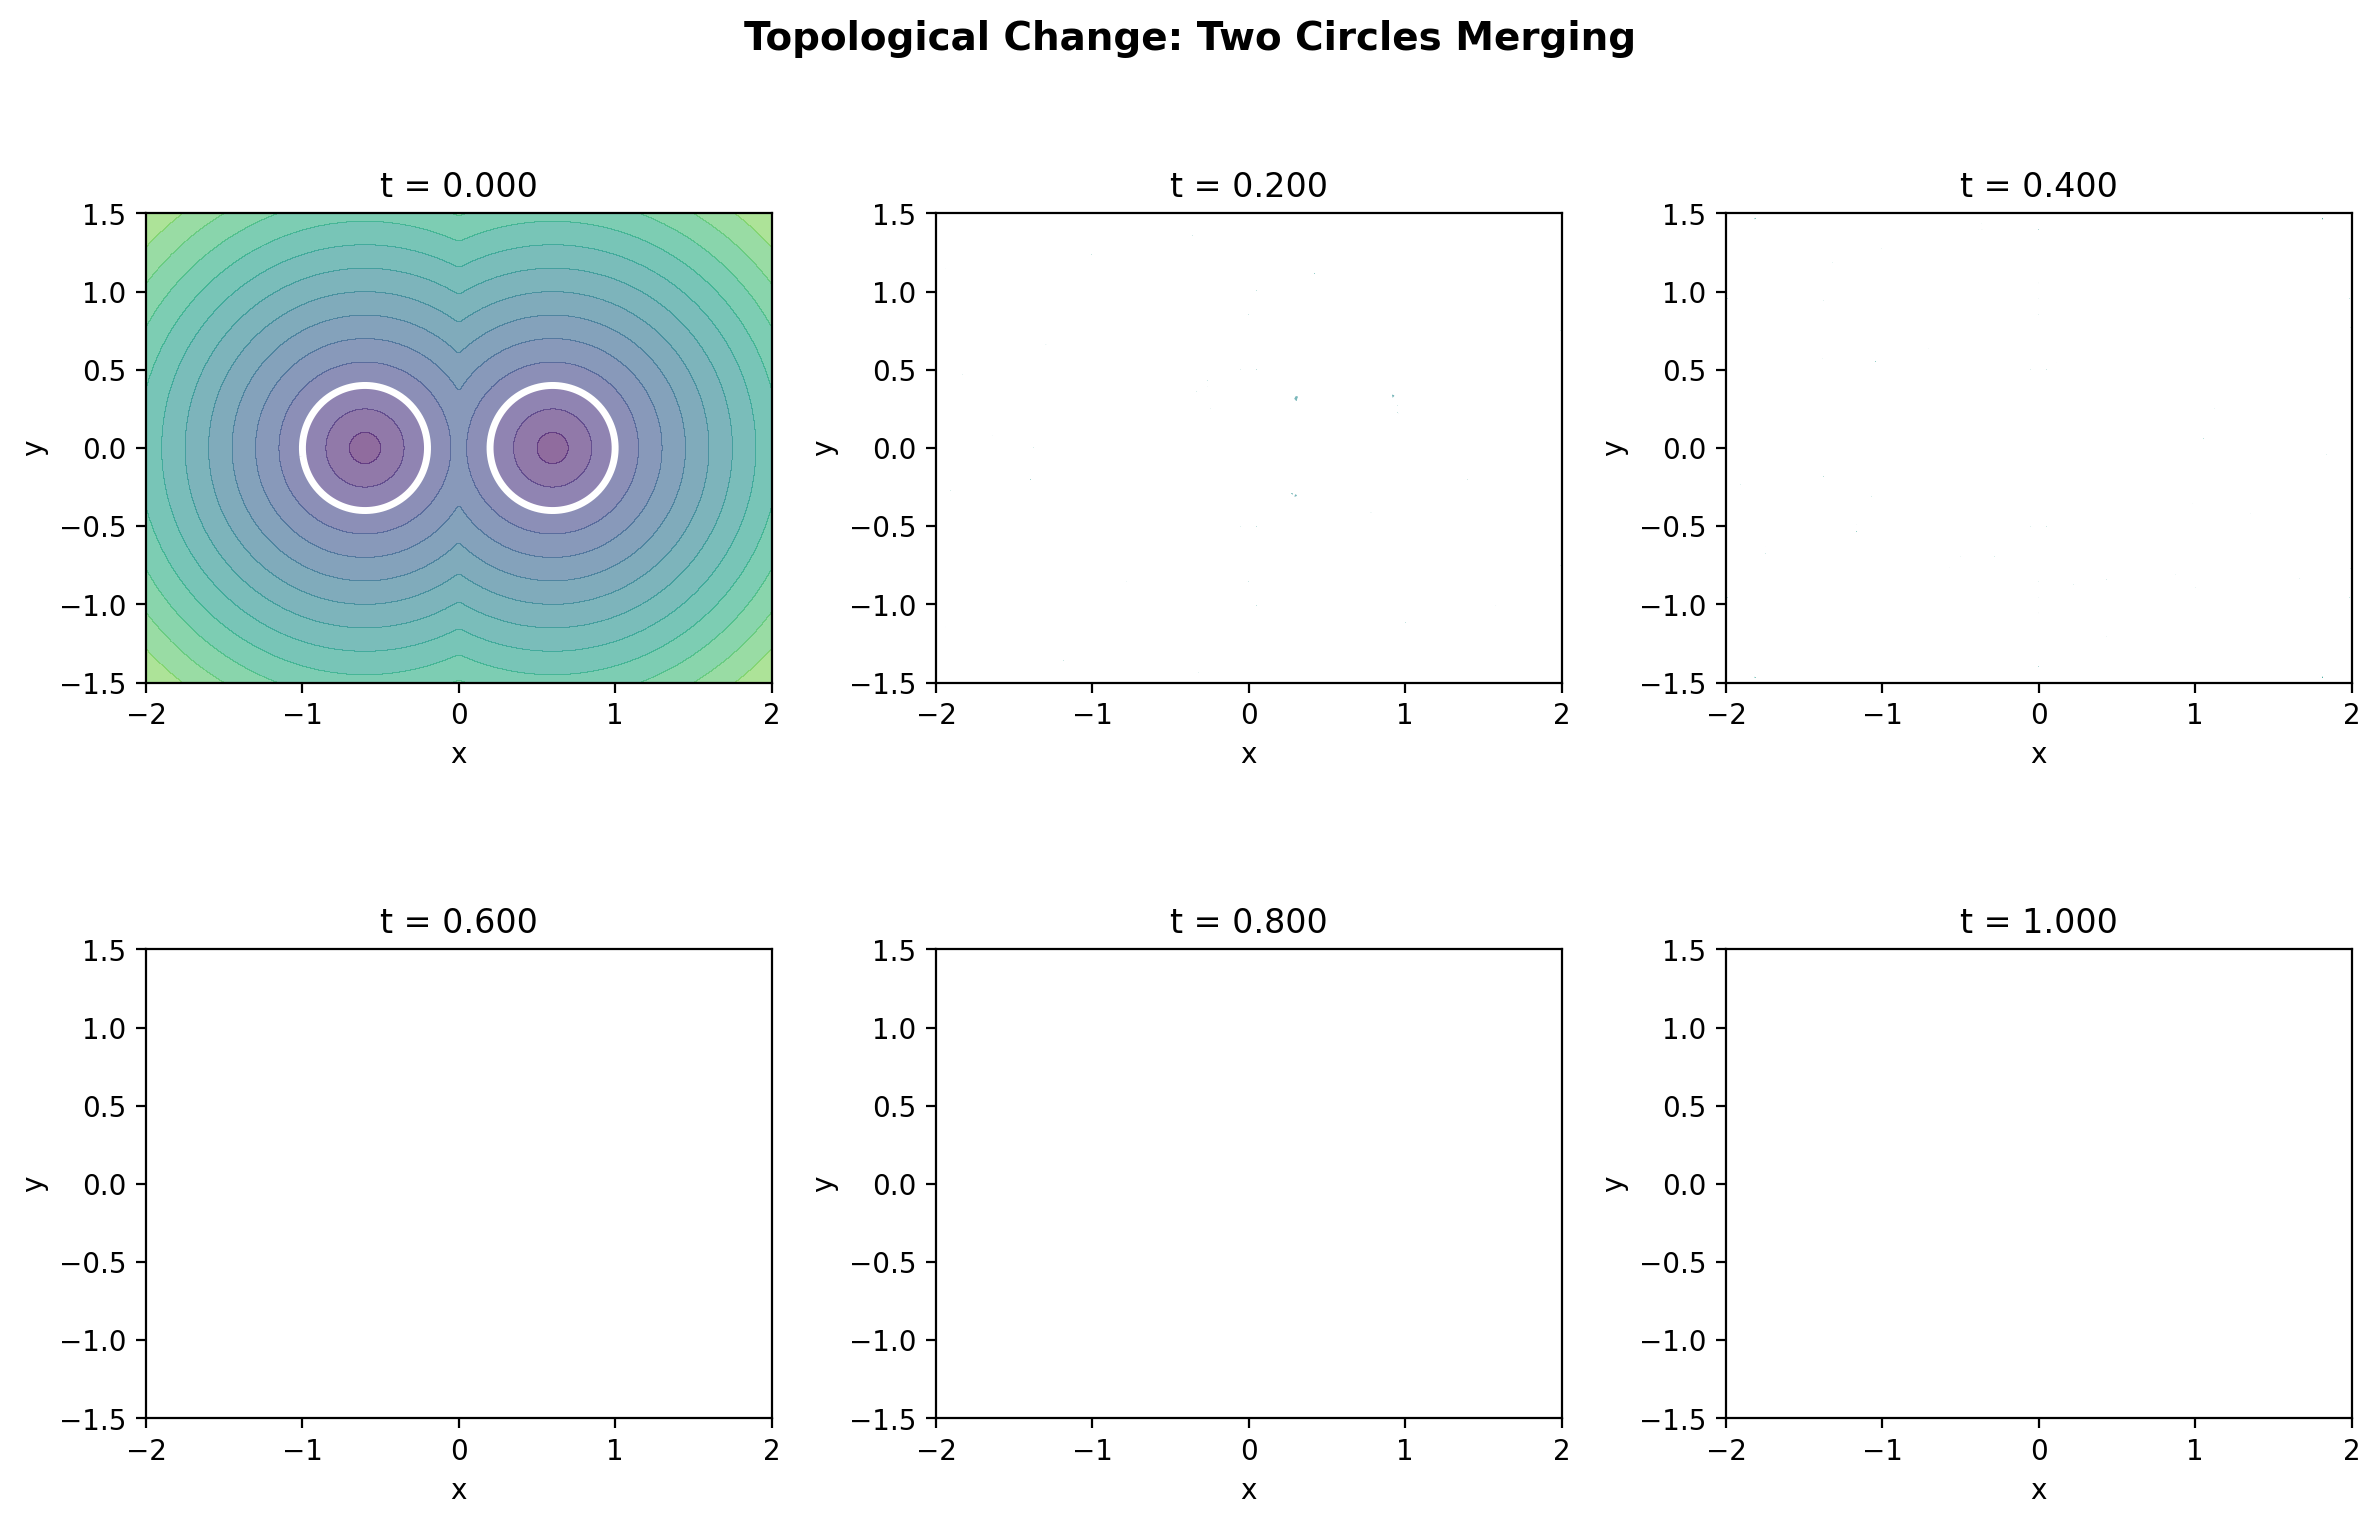

In [9]:
# Visualize merging
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (phi_snap, t) in enumerate(zip(merge_snapshots[:6], merge_times[:6])):
    ax = axes[idx]
    ax.contourf(X, Y, phi_snap, levels=20, cmap='viridis', alpha=0.6)
    ax.contour(X, Y, phi_snap, levels=[0], colors='white', linewidths=2.5)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.set_title(f't = {t:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

plt.suptitle('Topological Change: Two Circles Merging', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Reinitialization

Over time, $\phi$ can deviate from a signed distance function (where $|\nabla \phi| = 1$). **Reinitialization** restores this property by solving:

$$\frac{\partial \phi}{\partial \tau} = \text{sign}(\phi_0)(1 - |\nabla \phi|)$$

where $\tau$ is artificial time and $\phi_0$ is the initial condition for reinitialization.

In [10]:
def sign_function(phi, epsilon=1e-3):
    """Smoothed sign function."""
    return phi / np.sqrt(phi**2 + epsilon**2)

def reinitialize(phi, dx, dy, n_iter=20, dt_reinit=0.1):
    """Reinitialize phi to signed distance function using PDE method."""
    phi0 = phi.copy()
    sign_phi0 = sign_function(phi0)
    
    for _ in range(n_iter):
        phi_x, phi_y = compute_gradient(phi, dx, dy)
        grad_mag = np.sqrt(phi_x**2 + phi_y**2 + 1e-10)
        
        phi = phi + dt_reinit * sign_phi0 * (1 - grad_mag)
    
    return phi

# Demonstrate reinitialization
# Create a non-signed-distance function
phi_distorted = np.tanh(3 * phi_initial)  # Compress the gradient

# Compute gradient magnitudes before and after
phi_x_dist, phi_y_dist = compute_gradient(phi_distorted, dx, dy)
grad_mag_before = np.sqrt(phi_x_dist**2 + phi_y_dist**2)

phi_reinit = reinitialize(phi_distorted, dx, dy, n_iter=50)

phi_x_reinit, phi_y_reinit = compute_gradient(phi_reinit, dx, dy)
grad_mag_after = np.sqrt(phi_x_reinit**2 + phi_y_reinit**2)

print(f"Before reinitialization: |∇φ| mean = {grad_mag_before.mean():.3f}, std = {grad_mag_before.std():.3f}")
print(f"After reinitialization:  |∇φ| mean = {grad_mag_after.mean():.3f}, std = {grad_mag_after.std():.3f}")

Before reinitialization: |∇φ| mean = 0.776, std = 0.975
After reinitialization:  |∇φ| mean = 31414257474710508129268238757421645824.000, std = 253378844205819155704837685228915916800.000


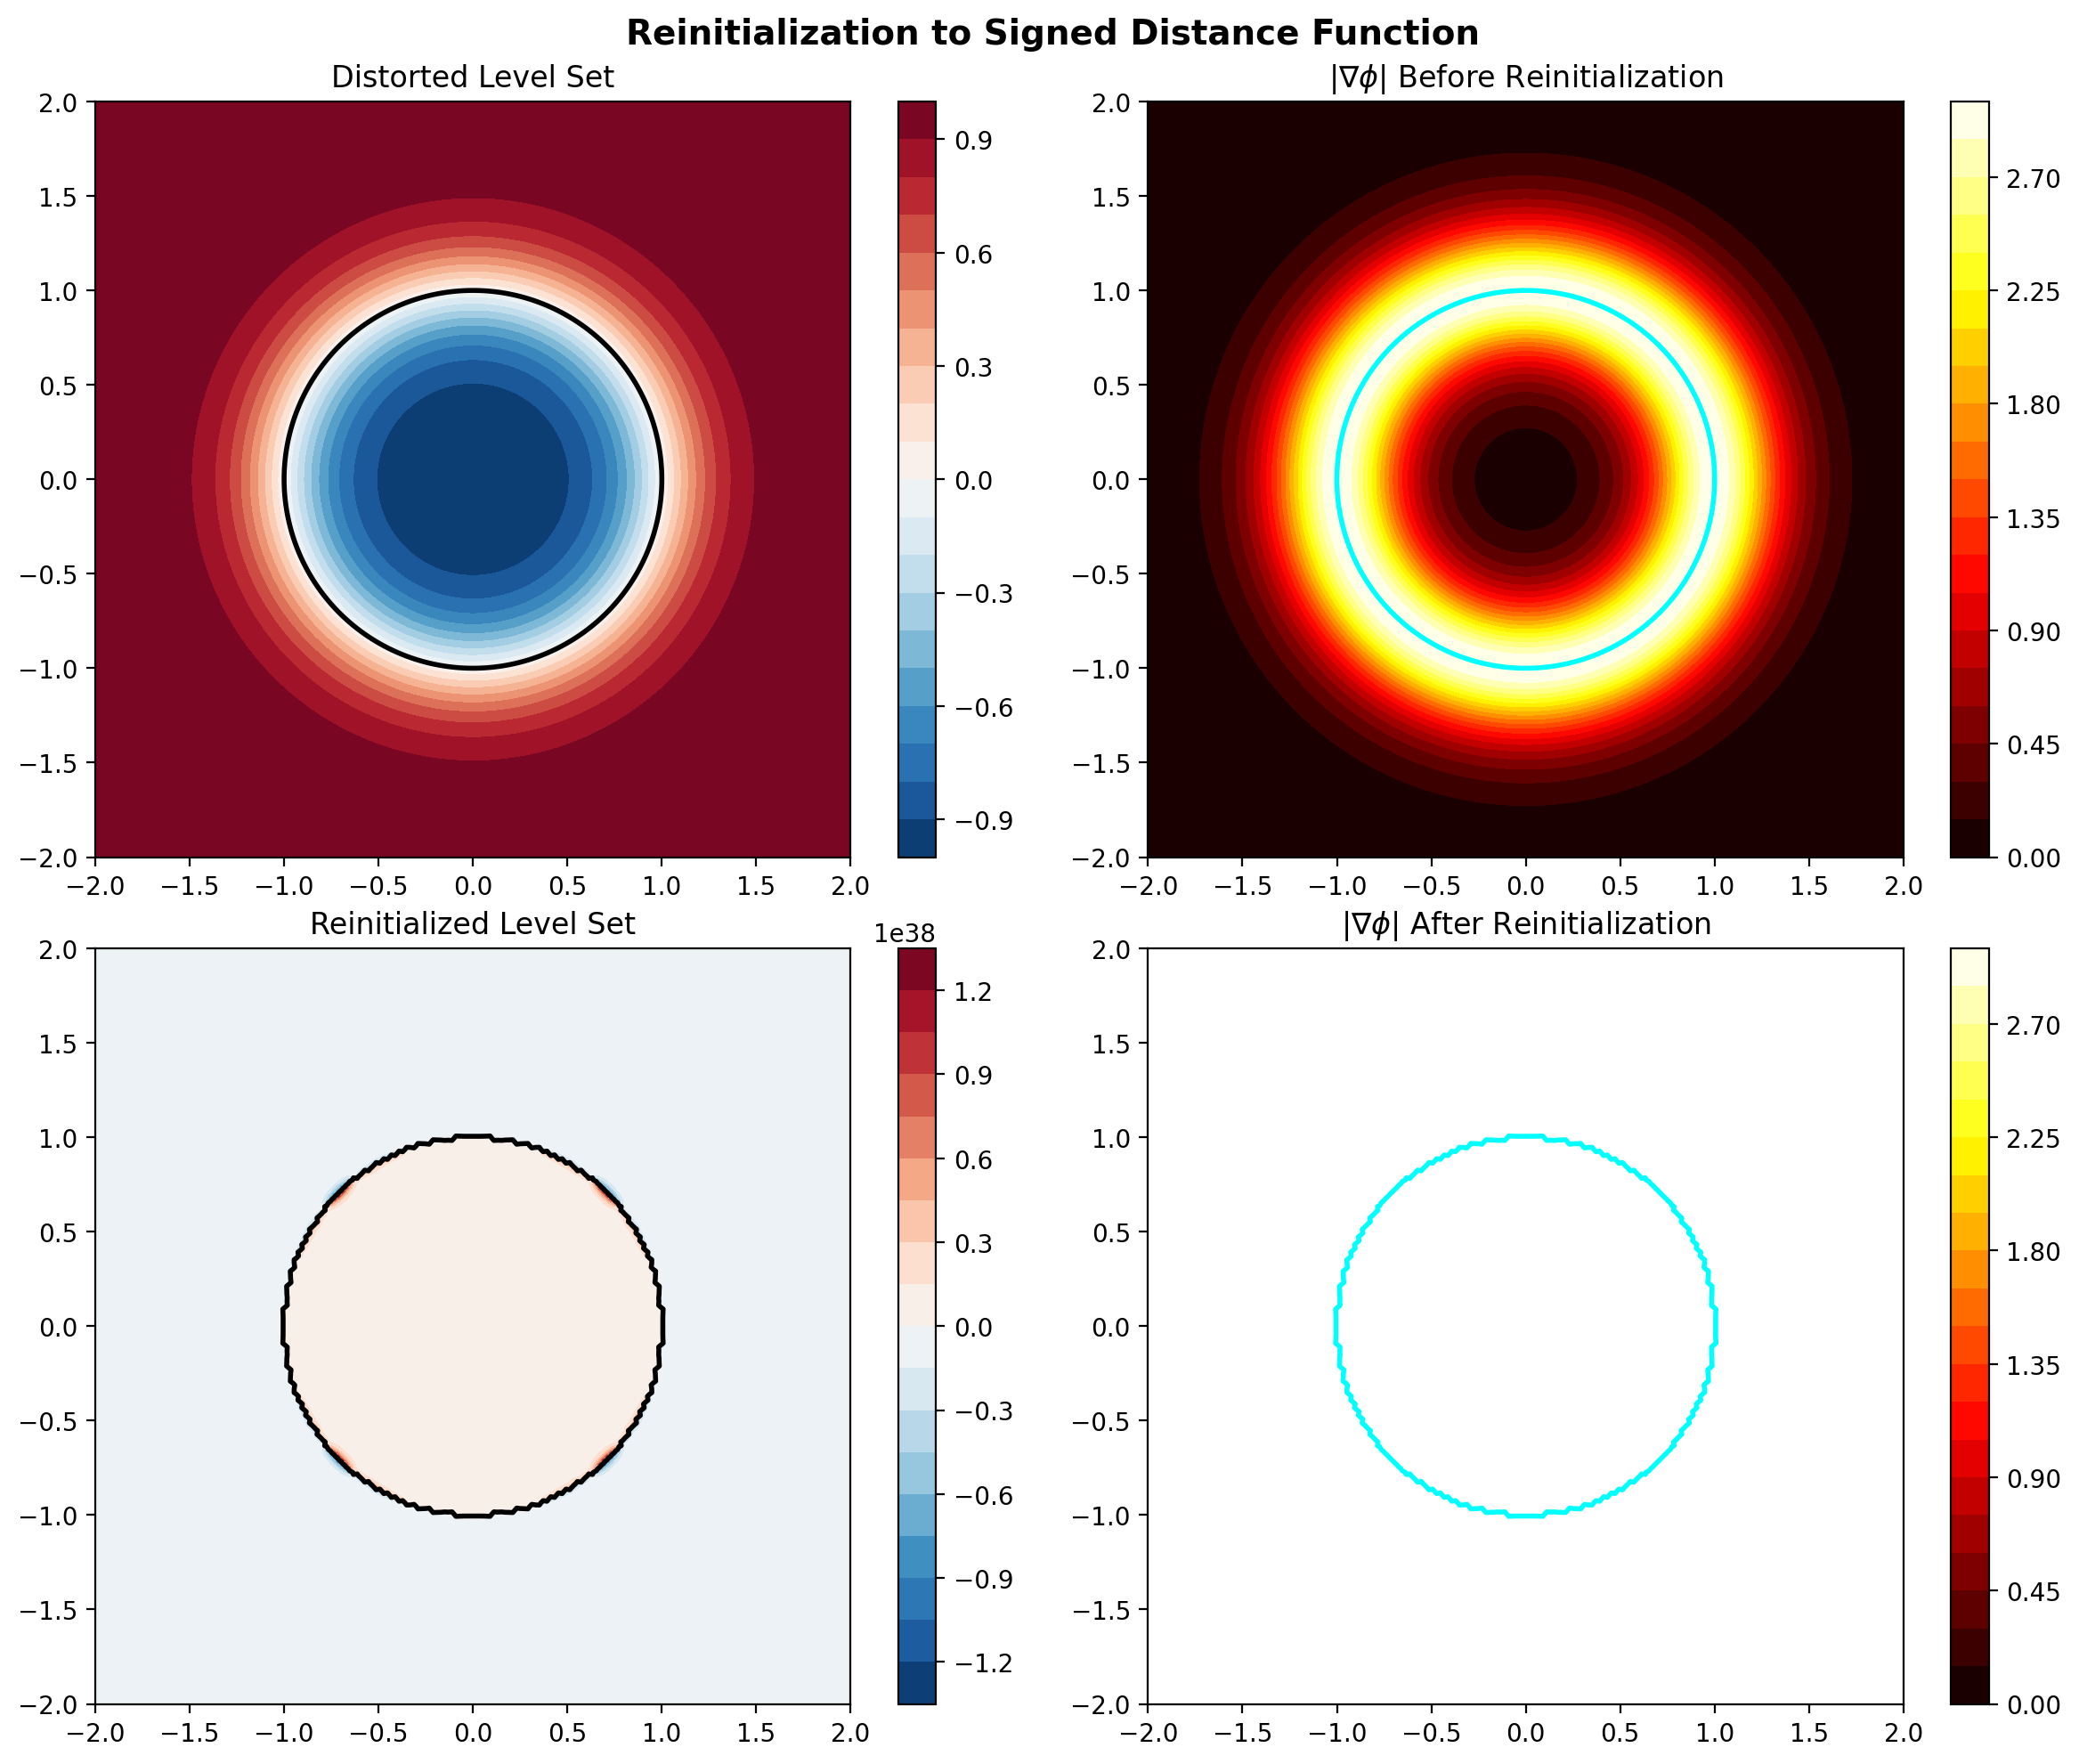

In [11]:
# Visualize reinitialization effect
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distorted phi
ax1 = axes[0, 0]
cs1 = ax1.contourf(X, Y, phi_distorted, levels=20, cmap='RdBu_r')
ax1.contour(X, Y, phi_distorted, levels=[0], colors='k', linewidths=2)
ax1.set_title('Distorted Level Set')
ax1.set_aspect('equal')
plt.colorbar(cs1, ax=ax1)

# Gradient magnitude before
ax2 = axes[0, 1]
cs2 = ax2.contourf(X, Y, grad_mag_before, levels=np.linspace(0, 3, 21), cmap='hot')
ax2.contour(X, Y, phi_distorted, levels=[0], colors='cyan', linewidths=2)
ax2.set_title(r'$|\nabla\phi|$ Before Reinitialization')
ax2.set_aspect('equal')
plt.colorbar(cs2, ax=ax2)

# Reinitialized phi
ax3 = axes[1, 0]
cs3 = ax3.contourf(X, Y, phi_reinit, levels=20, cmap='RdBu_r')
ax3.contour(X, Y, phi_reinit, levels=[0], colors='k', linewidths=2)
ax3.set_title('Reinitialized Level Set')
ax3.set_aspect('equal')
plt.colorbar(cs3, ax=ax3)

# Gradient magnitude after
ax4 = axes[1, 1]
cs4 = ax4.contourf(X, Y, grad_mag_after, levels=np.linspace(0, 3, 21), cmap='hot')
ax4.contour(X, Y, phi_reinit, levels=[0], colors='cyan', linewidths=2)
ax4.set_title(r'$|\nabla\phi|$ After Reinitialization')
ax4.set_aspect('equal')
plt.colorbar(cs4, ax=ax4)

plt.suptitle('Reinitialization to Signed Distance Function', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Summary Visualization

Let's create a comprehensive summary figure showing all the key aspects of the level set method.

Figure saved to plot.png


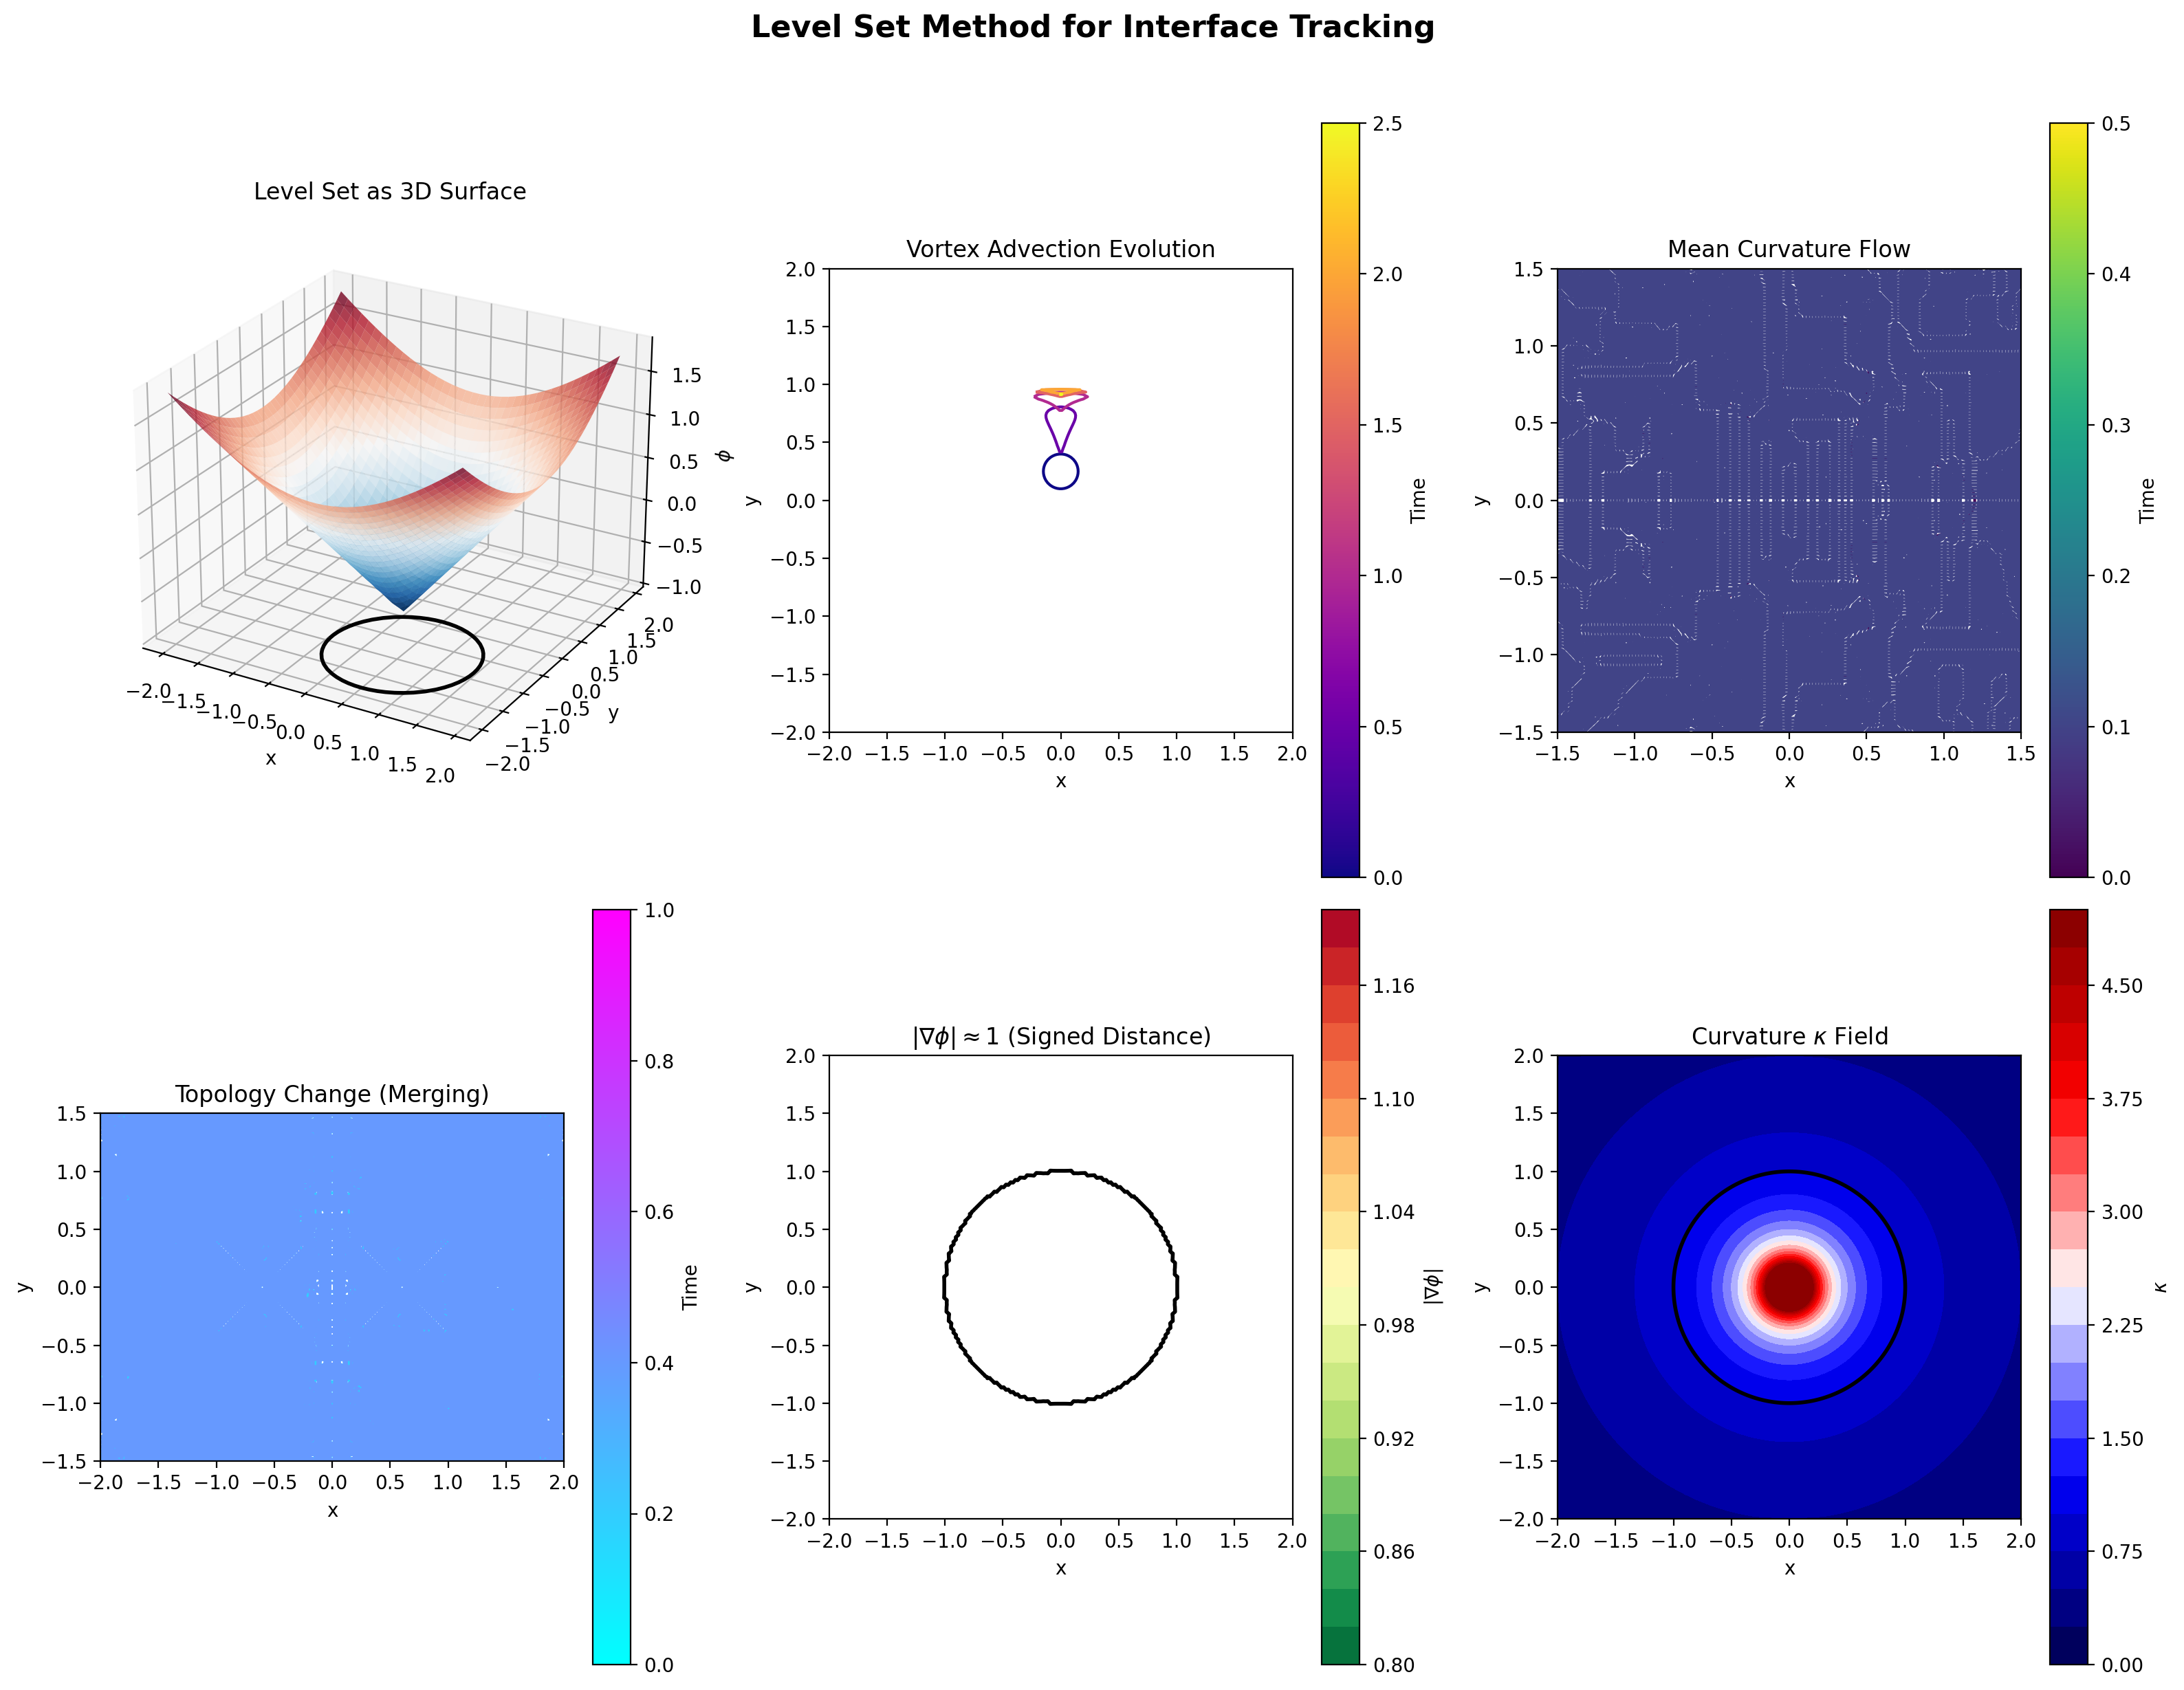

In [12]:
# Create comprehensive summary figure
fig = plt.figure(figsize=(16, 12))

# 1. 3D surface of level set function
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
X_coarse, Y_coarse = X[::5, ::5], Y[::5, ::5]
phi_coarse = phi_initial[::5, ::5]
surf = ax1.plot_surface(X_coarse, Y_coarse, phi_coarse, cmap='RdBu_r', alpha=0.8)
ax1.contour(X_coarse, Y_coarse, phi_coarse, levels=[0], colors='k', linewidths=2, offset=-1.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel(r'$\phi$')
ax1.set_title('Level Set as 3D Surface')
ax1.view_init(elev=25, azim=-60)

# 2. Vortex advection sequence
ax2 = fig.add_subplot(2, 3, 2)
colors = plt.cm.plasma(np.linspace(0, 1, len(snapshots[:6])))
for i, (phi_snap, t) in enumerate(zip(snapshots[:6], snapshot_times[:6])):
    ax2.contour(X, Y, phi_snap, levels=[0], colors=[colors[i]], linewidths=1.5)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.set_title('Vortex Advection Evolution')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=snapshot_times[5]))
plt.colorbar(sm, ax=ax2, label='Time')

# 3. Curvature flow
ax3 = fig.add_subplot(2, 3, 3)
colors_curv = plt.cm.viridis(np.linspace(0, 1, len(curv_snapshots[:6])))
for i, (phi_snap, t) in enumerate(zip(curv_snapshots[:6], curv_times[:6])):
    ax3.contour(X, Y, phi_snap, levels=[0], colors=[colors_curv[i]], linewidths=1.5)
ax3.set_xlim(-1.5, 1.5)
ax3.set_ylim(-1.5, 1.5)
ax3.set_aspect('equal')
ax3.set_title('Mean Curvature Flow')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
sm2 = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=curv_times[5]))
plt.colorbar(sm2, ax=ax3, label='Time')

# 4. Merging visualization
ax4 = fig.add_subplot(2, 3, 4)
colors_merge = plt.cm.cool(np.linspace(0, 1, len(merge_snapshots[:6])))
for i, (phi_snap, t) in enumerate(zip(merge_snapshots[:6], merge_times[:6])):
    ax4.contour(X, Y, phi_snap, levels=[0], colors=[colors_merge[i]], linewidths=1.5)
ax4.set_xlim(-2, 2)
ax4.set_ylim(-1.5, 1.5)
ax4.set_aspect('equal')
ax4.set_title('Topology Change (Merging)')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
sm3 = plt.cm.ScalarMappable(cmap='cool', norm=plt.Normalize(vmin=0, vmax=merge_times[5]))
plt.colorbar(sm3, ax=ax4, label='Time')

# 5. Signed distance property
ax5 = fig.add_subplot(2, 3, 5)
cs5 = ax5.contourf(X, Y, grad_mag_after, levels=np.linspace(0.8, 1.2, 21), cmap='RdYlGn_r')
ax5.contour(X, Y, phi_reinit, levels=[0], colors='k', linewidths=2)
ax5.set_title(r'$|\nabla\phi| \approx 1$ (Signed Distance)')
ax5.set_aspect('equal')
ax5.set_xlabel('x')
ax5.set_ylabel('y')
plt.colorbar(cs5, ax=ax5, label=r'$|\nabla\phi|$')

# 6. Curvature field
ax6 = fig.add_subplot(2, 3, 6)
kappa_init = compute_curvature(phi_initial, dx, dy)
kappa_clipped = np.clip(kappa_init, -5, 5)
cs6 = ax6.contourf(X, Y, kappa_clipped, levels=21, cmap='seismic')
ax6.contour(X, Y, phi_initial, levels=[0], colors='k', linewidths=2)
ax6.set_title(r'Curvature $\kappa$ Field')
ax6.set_aspect('equal')
ax6.set_xlabel('x')
ax6.set_ylabel('y')
plt.colorbar(cs6, ax=ax6, label=r'$\kappa$')

plt.suptitle('Level Set Method for Interface Tracking', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
plt.savefig('level_set_method_interface_tracking_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
print("Figure saved to plot.png")
plt.show()

## Conclusion

The **Level Set Method** provides an elegant framework for tracking evolving interfaces:

### Key Advantages
1. **Implicit representation** - Interfaces are defined as zero contours of $\phi$
2. **Automatic topology handling** - Merging and splitting occur naturally
3. **Easy geometric quantities** - Normals and curvature computed directly from $\phi$
4. **Extensible to any dimension** - Same formulation works in 2D, 3D, or higher

### Applications
- **Computational fluid dynamics**: Multiphase flow, free surfaces
- **Image processing**: Segmentation, edge detection
- **Materials science**: Crystal growth, phase transitions
- **Computer graphics**: Surface modeling, animation

### Key Equations Summary

| Quantity | Expression |
|----------|------------|
| Interface | $\Gamma = \{\mathbf{x} : \phi(\mathbf{x}) = 0\}$ |
| Level set equation | $\phi_t + \mathbf{v} \cdot \nabla\phi = 0$ |
| Normal motion | $\phi_t + F|\nabla\phi| = 0$ |
| Unit normal | $\mathbf{n} = \nabla\phi / |\nabla\phi|$ |
| Mean curvature | $\kappa = \nabla \cdot (\nabla\phi / |\nabla\phi|)$ |

### References
1. Osher, S., & Sethian, J. A. (1988). Fronts propagating with curvature-dependent speed. *Journal of Computational Physics*, 79(1), 12-49.
2. Sethian, J. A. (1999). *Level Set Methods and Fast Marching Methods*. Cambridge University Press.
3. Osher, S., & Fedkiw, R. (2003). *Level Set Methods and Dynamic Implicit Surfaces*. Springer.